# Import modules
CDC data set description link [here](https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?Component=Questionnaire&CycleBeginYear=2015)

In [1]:
import pdb
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, SelectKBest, mutual_info_classif, mutual_info_regression
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

import nhanes as nhanes

%matplotlib notebook

## Settings

In [2]:
DATA_PATH = 'C:/Users/allen/Documents/Git-Repos/Opportunistic/CDC/NHANES/'
DATASET = 'cancer'

### Note: 
The code below loads each dataset: dataset_features, dataset_targets

Here, all datasets are defined explicitly (see nhanes.py).
*Caution* Very long computation, proceed with care

In [3]:
ds = nhanes.Dataset(DATA_PATH)
ds.load_cancer()
n_fe = ds.features.shape[1]
n_classes = 2

Processing: Dietary\DRXTOT_B.XPT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

Processing: Laboratory\TRIGLY_H.XPT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

Processing: Questionnaire\WHQ_H.XPT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

Extract the features and targets.

In [4]:
features = ds.features.values
targets = ds.targets.values

indx = np.argwhere(targets != 3)
dataset_features = features[indx.flatten()]
dataset_targets = targets[indx.flatten()]

dataset_features = pd.DataFrame(dataset_features, columns=ds.features.columns)
dataset_targets = pd.DataFrame(dataset_targets, columns=ds.targets.columns, dtype='float64')
print(dataset_targets.shape)
# Pre-fix
# dataset_features = ds.features
# dataset_targets = ds.targets

(98908, 1)


## Preprocessing of Data
### Drop features with too-low variance

In [5]:
dataset_features_sel = dataset_features.copy()

# var_thresh = .001
# dropped_keys = []
# for key, value in dataset_features_sel.iteritems():
#     if(value.var() < var_thresh):
#         dataset_features_sel.drop(key, axis=1, inplace=True)
#         dropped_keys.append(key)

# print("Dropped %i keys, they were:\n %s" %(len(dropped_keys), dropped_keys))

### Calculate feature importance

In [ ]:
importances = []
num_trees = 2
for i in range(num_trees):
    print('0% [',i*'.',(num_trees-i)*'-','] 100%', end='\r')
    clf = ExtraTreesClassifier(n_estimators=50)
    clf = clf.fit(dataset_features_sel.values, dataset_targets.values.ravel())
    importances.append(clf.feature_importances_)

# print(importances)

#### Drop Threshhold helper function

In [7]:
def drop_threshold(threshold, df_data, df_threshold):
    mi = df_threshold # mutual information dataframe
    df = df_data # data containing dataframe
    to_keep = []
    # mi = mi.sort_values(by =0, axis=1) #sorts the values ascending
    # print(mi)
    var_counter = 0
    for col in mi:
        var_counter += mi[col].iloc[0]
        to_keep.append(col)
        if(var_counter > threshold):
            break
    if(len(to_keep) > 0):
        return pd.DataFrame(df[to_keep].copy(), dtype='float64')
    else:
        raise NotImplementedError


### Drop low importance features

In [8]:
importances_mean = np.array(importances)
importances_mean = np.mean(importances_mean, axis=0)
importances_mean = importances_mean.reshape((1, len(importances_mean)))
importances_mean = pd.DataFrame(importances_mean, columns=ds.features.columns, dtype='float64')
importances_mean = importances_mean.sort_values(by=0, axis=1, ascending=False) #sorts the values ascending

df_importances = drop_threshold(0.90, dataset_features_sel ,importances_mean)
print(df_importances.shape)

(98908, 65)


### Seperate one-hot encoded, discrete, and continuous features

In [9]:
# onehot encoded
dataset_features_onehot = df_importances.filter(regex=(".*#.*"))
# Continuous 
dataset_features_cont = df_importances.drop(columns=df_importances.filter(regex=(".*#.*")))

# dataset_features_disc = []
# for key, value in dataset_features_cont.iteritems():
#     # discrete were normalized so they should have a mean of .5, and we expect 4 of them
#     if(value.mean() >= .5 and (abs(value.std()) >= .75)):
#         dataset_features_disc.append(dataset_features_cont[key])
#         dataset_features_cont.drop(key, axis=1, inplace=True)
# # discrete
# dataset_features_disc = pd.concat(dataset_features_disc, axis=1)
print(df_importances.shape)
print(dataset_features_cont.shape)
print(dataset_features_onehot.shape)
# print(dataset_features_disc.columns)

(98908, 65)
(98908, 44)
(98908, 21)


### Calculate PCA to drop features

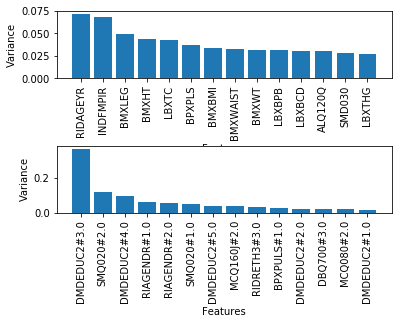

In [10]:
# dfs = [dataset_features_cont.copy(), dataset_features_disc.copy(), dataset_features_onehot.copy()]
dfs_out = [dataset_features_cont.copy(), dataset_features_onehot.copy()]
titles = ['Continuous Data', 'Categorical Data']
pca_dfs = []
gfs = 15 # Number of features to graph
gfs -= 1
i = 0
for df in dfs_out:    
#     print(df.shape)
    pca = PCA() # no args, so keep all columns, n_components=2
    pca.fit(df)
    var_ratio = pca.explained_variance_ratio_
    var_ratio = var_ratio.reshape((1, len(var_ratio)))
    pca_dfs.append(pd.DataFrame(data=var_ratio, columns=df.columns))
    # Visualize PCA:
    idx = [i for i in range(len(df.columns))]
    cols = [i for i in df.columns]
    plt.subplot(len(dfs_out),1,i+1)
    plt.subplots_adjust(hspace = 1, top=1, bottom=.3)
    plt.bar(idx[0:gfs], pca.explained_variance_ratio_[0:gfs])
    plt.xticks(idx[0:gfs], df.columns[0:gfs], rotation='vertical')
    plt.xlabel('Features')
    plt.ylabel('Variance')
#     plt.title(titles[i])
    i+=1
plt.show()

# print(pca_dfs.shape)


### Remove columns that account for too little of the variance

In [11]:
pca_dfs_out = []

for i in range(len(dfs_out)):
    pca_dfs_out.append(drop_threshold(0.95, dfs_out[i] ,pca_dfs[i]))

for df in pca_dfs_out:
    print(df.shape)

df_final = pd.concat(pca_dfs_out, axis=1)
print(df_final.shape)

(98908, 33)
(98908, 13)
(98908, 46)


## Train/Test Separation

In [13]:
perm = np.random.permutation(dataset_targets.shape[0])
dataset_targets_vals = np.ravel(dataset_targets.values) # unroll the column to the correct vector shape

dataset_features = df_final.values[perm]
dataset_targets = dataset_targets_vals[perm]

print("dataset_features Shape: %s, dataset_targets Shape: %s" % (dataset_features.shape, dataset_targets.shape))

def get_batch(n_size, phase):
    # select indices
    n_samples = dataset_features.shape[0]
    n_classes = int(dataset_targets.max() + 1)
    if phase == 'test':
        inds_sel = np.arange(0, int(n_samples*0.15), 1)
    elif phase == 'validation':
        n_samples = dataset_features.shape[0]
        inds_sel = np.arange(int(n_samples*0.15), int(n_samples*0.30), 1)
    elif phase == 'train':
        n_samples = dataset_features.shape[0]
        inds_sel = np.arange(int(n_samples*0.30), n_samples, 1)
    else:
        raise NotImplementedError
    inds_sel = np.random.permutation(inds_sel)
    batch_inds = []
    for cl in range(n_classes):
        inds_cl = inds_sel[dataset_targets[inds_sel] == cl]
        batch_inds.extend(inds_cl[:n_size//n_classes])
    batch_inds = np.random.permutation(batch_inds)
    
    return dataset_features[batch_inds], dataset_targets[batch_inds]

dataset_features Shape: (98908, 46), dataset_targets Shape: (98908,)


## Classification

In [14]:
trials = 30
accu_tst_RFC = []
accu_tst_SVC = []
accu_tst_LR = []

for i in range(trials):
    print('0% [',i*'.',(trials-i)*'-','] 100%', end='\r')
    features_trn, targets_trn = get_batch(n_size=5000, phase='train')
    features_tst, targets_tst = get_batch(n_size=1000, phase='test')

    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(features_trn, targets_trn)
    preds_tst = clf.predict(features_tst)
    accu = np.mean(preds_tst==targets_tst)
    # print('accu_tst_RFC', accu)
    accu_tst_RFC.append(accu)

    clf = SVC(gamma='auto')
    clf.fit(features_trn, targets_trn)
    preds_tst = clf.predict(features_tst)
    accu = np.mean(preds_tst==targets_tst)
    # print('accu_tst_SVC', accu)
    accu_tst_SVC.append(accu)

    clf = LogisticRegression(solver='lbfgs', max_iter=200, multi_class='auto')
    clf.fit(features_trn, targets_trn)
    preds_tst = clf.predict(features_tst)
    accu = np.mean(preds_tst==targets_tst)
    # print('accu_tst_LR', accu)
    accu_tst_LR.append(accu)
    
accu_tst_RFC = np.array(accu_tst_RFC)
accu_tst_SVC = np.array(accu_tst_SVC)
accu_tst_LR = np.array(accu_tst_LR)

print('accu_tst_RFC %s, accu_tst_SVC %s, accu_tst_LR %s'
      % (np.mean(accu_tst_RFC), np.mean(accu_tst_SVC), np.mean(accu_tst_LR)))

accu_tst_RFC 0.8214000000000001, accu_tst_SVC 0.8132, accu_tst_LR 0.7914666666666668


In [15]:
print(classification_report(targets_tst, preds_tst))

              precision    recall  f1-score   support

         0.0       0.76      0.80      0.78       500
         1.0       0.79      0.75      0.77       500

   micro avg       0.78      0.78      0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.78      0.78      0.78      1000



### Accuracies from baseline: 
#### Cancer (ds.load_cancer()):
* accu_tst_RFC 0.758
* accu_tst_SVC 0.759
* accu_tst_LR 0.768

### Calculate mutual information
*Caution* Very long computation, proceed with care
Note: disused because of enmormous memory requirements

In [ ]:
# dataset_features_sel_vals = dataset_features_sel.values
# dataset_targets_vals = np.ravel(dataset_targets.values) # unroll the column to the correct vector shape
# # dfs = [dataset_features_cont.copy(), dataset_features_disc.copy(), dataset_features_onehot.copy()]
# # retrieve values from dfs_out for subsequent steps if this comes after PCA
# # dataset_features_cont = dfs_out[0]
# # dataset_features_disc = dfs_out[1]
# # dataset_features_onehot = dfs_out[2]

# print('0% [---] 100%', end='\r')
# mutual_info_cont = mutual_info_regression(dataset_features_cont.values, dataset_targets_vals)
# print('0% [+--] 100%', end='\r')
# # mutual_info_disc = mutual_info_regression(dataset_features_disc.values, dataset_targets_vals)
# # print('0% [++-] 100%', end='\r')
# mutual_info_onehot = mutual_info_classif(dataset_features_onehot.values, dataset_targets_vals)
# print('0% [+++] 100%', end='\r')

### Convert mutual info into dataframes and inspect

In [ ]:
# if(mutual_info_cont.shape[0] != 1): # we only need to run this portion of the block once
#     mutual_info_cont = mutual_info_cont.reshape((1, len(mutual_info_cont)))
#     mutual_info_disc = mutual_info_disc.reshape((1, len(mutual_info_disc))) 
#     mutual_info_onehot = mutual_info_onehot.reshape((1, len(mutual_info_onehot))) 


# mutual_info_cont_df = pd.DataFrame(data=mutual_info_cont, columns=dataset_features_cont.columns)
# mutual_info_disc_df = pd.DataFrame(data=mutual_info_disc, columns=dataset_features_disc.columns)
# mutual_info_onehot_df = pd.DataFrame(data=mutual_info_onehot, columns=dataset_features_onehot.columns)

### Dropping features with low mutual information
    __Conditioned on target variable__

In [ ]:
# mi_dfs = [mutual_info_cont_df, mutual_info_disc_df, mutual_info_onehot_df]
# dfs = [dataset_features_cont, dataset_features_disc, dataset_features_onehot]
# dfs_out = []

# for i in range(len(dfs)):
#     mi = mi_dfs[i] # mutual information dataframe
#     df = dfs[i] # data containing dataframe
#     to_drop = []
#     mean = 0.25*mi.mean(axis=1)
    
#     # mi = mi.sort_values(by =0, axis=1) #sorts the values ascending
#     # print(mi)
#     for col in mi:
#         if(mi[col].iloc[0] < mean).all():
#             to_drop.append(col)
#     if(len(to_drop) > 0):
#         dfs_out.append(pd.DataFrame(df.drop(columns=to_drop)))
    
# dfs_out = pd.concat(dfs_out, axis=1)
# # Retained columns
# print(dfs_out.columns)
# # output shape
# print(dfs_out.shape)